## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.semantic_segmentation.datasets.voc import (LABEL_COLORS,
                                                          VocSegmentation)
from torchlake.semantic_segmentation.models.parsenet import ParseNet
from tqdm import tqdm

# setting

In [2]:
artifacts_path = Path("../../artifacts/parsenet")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=preprocess,
)

test_dataset = VocSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

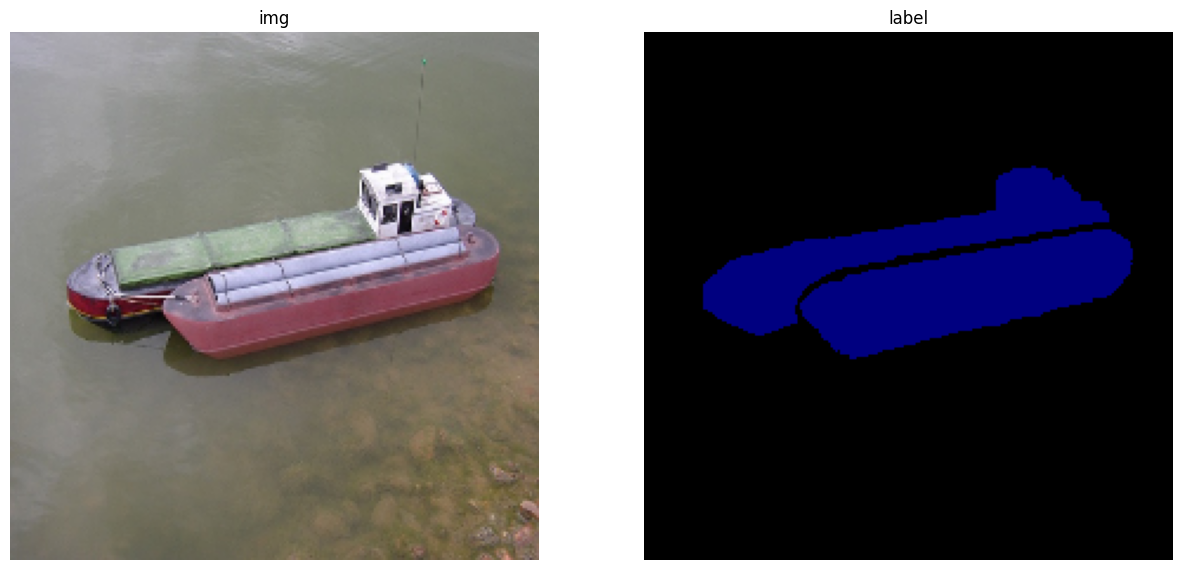

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# train

In [10]:
model = ParseNet(NUM_CLASS + 1, frozen_backbone=True).to(DEVICE)

In [11]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
ParseNet                                      --
├─VGGFeatureExtractor: 1-1                    --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15                      (590,080)
│    │    └─ReLU: 3

In [12]:
EPOCHES = 30

In [13]:
trainer = ClassificationTrainer(EPOCHES, DEVICE)

In [14]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [15]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [16]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 91/91 [02:54<00:00,  1.92s/it]


epoch 1 : 0.07080847675819973


100%|██████████| 91/91 [00:28<00:00,  3.15it/s]


epoch 2 : 0.03461204360720221


100%|██████████| 91/91 [00:28<00:00,  3.19it/s]


epoch 3 : 0.025954003415101175


100%|██████████| 91/91 [00:31<00:00,  2.85it/s]


epoch 4 : 0.01981038415988723


100%|██████████| 91/91 [00:30<00:00,  2.99it/s]


epoch 5 : 0.015313459938944696


100%|██████████| 91/91 [00:32<00:00,  2.79it/s]


epoch 6 : 0.01263526246811335


100%|██████████| 91/91 [00:43<00:00,  2.08it/s]


epoch 7 : 0.010889591526362923


100%|██████████| 91/91 [00:29<00:00,  3.08it/s]


epoch 8 : 0.009604048270445604


100%|██████████| 91/91 [00:31<00:00,  2.91it/s]


epoch 9 : 0.008608353887121755


100%|██████████| 91/91 [00:28<00:00,  3.16it/s]


epoch 10 : 0.007953652400769048


100%|██████████| 91/91 [00:27<00:00,  3.29it/s]


epoch 11 : 0.007458754835629856


100%|██████████| 91/91 [00:29<00:00,  3.13it/s]


epoch 12 : 0.006926204118836712


100%|██████████| 91/91 [00:27<00:00,  3.30it/s]


epoch 13 : 0.006501341279555153


100%|██████████| 91/91 [00:28<00:00,  3.22it/s]


epoch 14 : 0.006176099933397312


100%|██████████| 91/91 [00:27<00:00,  3.33it/s]


epoch 15 : 0.005883005222530811


100%|██████████| 91/91 [00:29<00:00,  3.10it/s]


epoch 16 : 0.005655869560131988


100%|██████████| 91/91 [00:29<00:00,  3.08it/s]


epoch 17 : 0.005554595445333928


100%|██████████| 91/91 [00:27<00:00,  3.35it/s]


epoch 18 : 0.005325753231543106


100%|██████████| 91/91 [00:27<00:00,  3.33it/s]


epoch 19 : 0.005174061744013331


100%|██████████| 91/91 [00:27<00:00,  3.32it/s]


epoch 20 : 0.005027269747538062


100%|██████████| 91/91 [00:27<00:00,  3.26it/s]


epoch 21 : 0.004929208713532477


100%|██████████| 91/91 [00:28<00:00,  3.19it/s]


epoch 22 : 0.004797720519191289


100%|██████████| 91/91 [00:28<00:00,  3.19it/s]


epoch 23 : 0.004696007173221845


100%|██████████| 91/91 [00:28<00:00,  3.16it/s]


epoch 24 : 0.004612873515605435


100%|██████████| 91/91 [00:32<00:00,  2.83it/s]


epoch 25 : 0.004532816827522366


100%|██████████| 91/91 [00:29<00:00,  3.10it/s]


epoch 26 : 0.004456613307491273


100%|██████████| 91/91 [00:28<00:00,  3.22it/s]


epoch 27 : 0.004405250248325231


100%|██████████| 91/91 [00:27<00:00,  3.29it/s]


epoch 28 : 0.004354425618977665


100%|██████████| 91/91 [00:28<00:00,  3.18it/s]


epoch 29 : 0.004310225458958974


100%|██████████| 91/91 [00:29<00:00,  3.10it/s]

epoch 30 : 0.00412075475349531


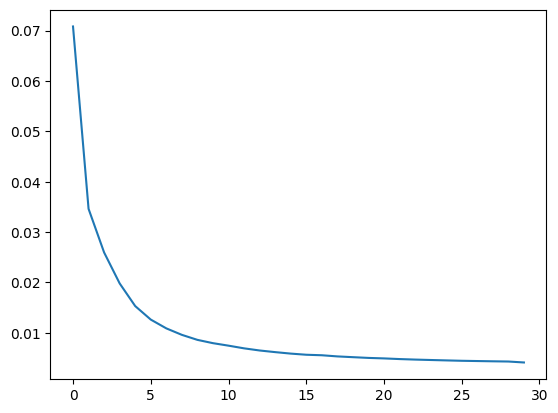

In [17]:
plt.plot(training_loss)

In [18]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
ParseNet                                      --
├─VGGFeatureExtractor: 1-1                    --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─ReLU: 3-2                         --
│    │    └─Conv2d: 3-3                       (36,928)
│    │    └─ReLU: 3-4                         --
│    │    └─MaxPool2d: 3-5                    --
│    │    └─Conv2d: 3-6                       (73,856)
│    │    └─ReLU: 3-7                         --
│    │    └─Conv2d: 3-8                       (147,584)
│    │    └─ReLU: 3-9                         --
│    │    └─MaxPool2d: 3-10                   --
│    │    └─Conv2d: 3-11                      (295,168)
│    │    └─ReLU: 3-12                        --
│    │    └─Conv2d: 3-13                      (590,080)
│    │    └─ReLU: 3-14                        --
│    │    └─Conv2d: 3-15                      (590,080)
│    │    └─ReLU: 3

In [19]:
model_path = artifacts_path.joinpath('parsent.pth')

In [20]:
torch.save(model.state_dict(), model_path)

In [21]:
get_file_size(model_path)

'78.35MiB'

# inference

In [22]:
model.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

### dice coef

In [23]:
from torchmetrics.classification import jaccard

In [24]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(DEVICE)

        # B, C+1, H, W
        output = model(img)
        output = output.argmax(dim=1).detach().cpu()

        labels = labels.long()
        metric.update(output, labels)

100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


In [25]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.75 
bicycle        : 0.41 
bird           : 0.84 
boat           : 0.76 
bottle         : 0.78 
bus            : 0.91 
car            : 0.82 
cat            : 0.89 
chair          : 0.63 
cow            : 0.78 
diningtable    : 0.88 
dog            : 0.8  
horse          : 0.7  
motorbike      : 0.77 
person         : 0.78 
pottedplant    : 0.52 
sheep          : 0.8  
sofa           : 0.82 
train          : 0.89 
tvmonitor      : 0.83 
----------------------
total          : 0.77 


### for image in dataset

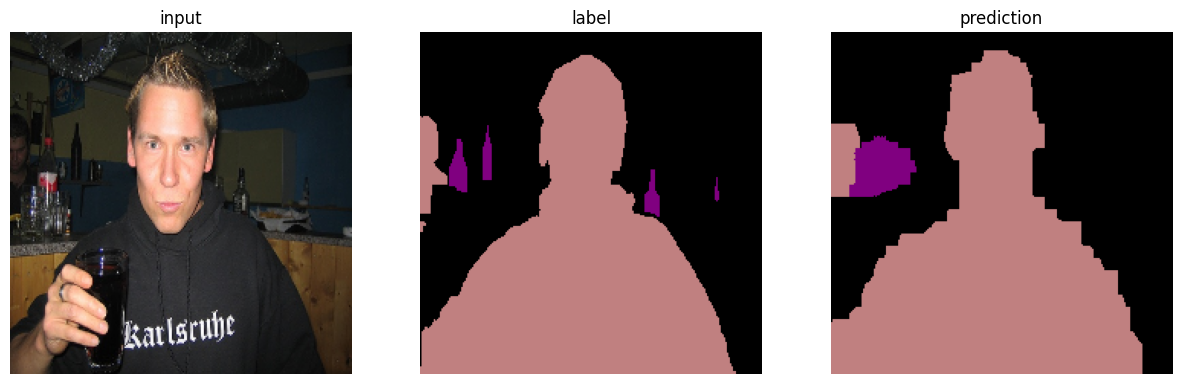

In [26]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

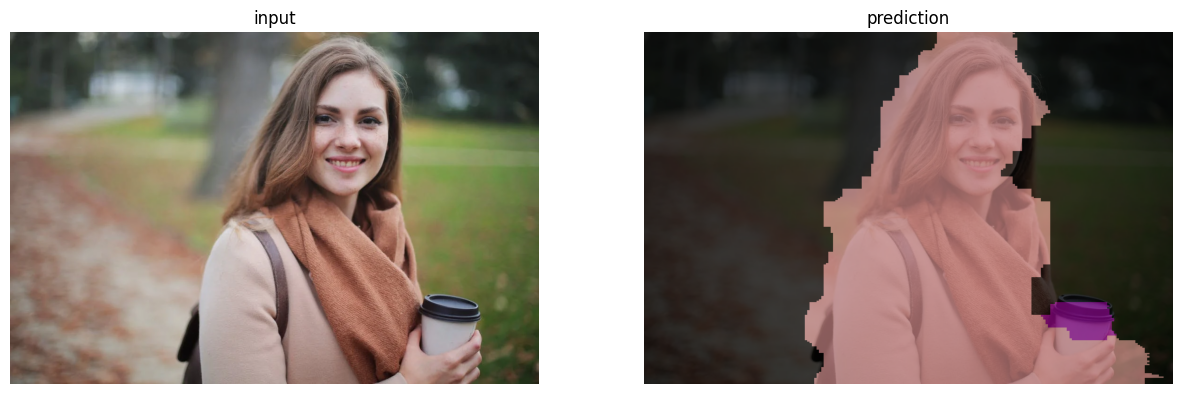

In [27]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )